# Binomial Method Bermudan Option pricing

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

## Building the model
We start defining the matrices representing the stock and option values

In [4]:
# Defines a lower triangular matrix describing the stock dynamics
def binomial_tree_stock(S, T, sigma, n):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    
    stock_tree = np.zeros((n + 1, n + 1))
    stock_tree[0, 0] = S
    
    for i in range(1, n + 1):
        stock_tree[i, i] = stock_tree[i - 1, i - 1] * u
        for j in range(i, n + 1):
            stock_tree[j, i - 1] = stock_tree[j - 1, i - 1] * d
            
    return stock_tree


# Payoff function for call or puts with stock price S and strike price K
def payoff(S, K, style):
    if style == 'call':
        return max(S - K, 0)
    elif style == 'put':
        return max(K - S, 0)
    else:
        raise ValueError("Invalid option style. Style must be 'call' or 'put'.")


# Returns a lower triangular matrix describing the Bermudan option price dynamics
def binomial_bermudan_option_pricing(S, K, T, r, sigma, n, early_exercise_dates, style):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize option value matrix
    option_values = np.zeros((n + 1, n + 1))

    # Calculate the option values at expiration
    for i in range(n + 1):
        option_values[n][i] = payoff(S * (u ** i) * (d ** (n - i)), K, style)

    # Calculate the option values at earlier exercise dates
    for t in range(n - 1, -1, -1):
        for i in range(t + 1):
            hold_value = np.exp(-r * dt) * (p * option_values[t + 1][i+1] + (1 - p) * option_values[t + 1][i])
            if round(t * dt,2) in early_exercise_dates:
                option_values[t][i] = max(payoff(S * (u ** i) * (d ** (t - i)), K, style), hold_value)
            else:
                option_values[t][i] = hold_value

    return option_values


# Defines a lower triangular matrix describing the dynamics of an American option for the model
def binomial_american_option_pricing(S, K, T, r, sigma, n, style):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize option value matrix
    option_values = np.zeros((n + 1, n + 1))

    # Calculate the option values at expiration
    for i in range(n + 1):
        option_values[n][i] = payoff(S * (u ** i) * (d ** (n - i)), K, style)

    # Calculate the option values at earlier exercise dates
    for t in range(n - 1, -1, -1):
        for i in range(t + 1):
            hold_value = np.exp(-r * dt) * (p * option_values[t + 1][i+1] + (1 - p) * option_values[t + 1][i])
            option_values[t][i] = max(payoff(S * (u ** i) * (d ** (t - i)), K, style), hold_value)

    return option_values


# Defines a lower triangular matrix describing the Delta parameter in all possible states for any option in the binomial model
def binomial_delta(option_values, sigma, T, n, S):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    
    delta=np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1):
            delta[i][j] = (option_values[i + 1][j + 1] - option_values[i + 1][j]) / (S * (d ** (i - j)) * (u ** (j + 1)) - S * (d ** (i + 1 - j)) * (u ** j))
            
    return delta
    

## Initializing the parameters and comparing with the American option
After initializing the parameters, we compare the Bermudan option values with the American option values (with the same parameters). Note that it should hold in general
$$
V_A\geq V_B \geq V_E,
$$
where $V_A,V_B,V_E$ are respectively the values of the American, Bermudan and European option (of the same type, with the same parameters and on the same underlying). For a call option we know that $V_A=V_E$, hence it should hold 
$$
V_A=V_B.
$$
For a put option instead in general
$$
V_A>V_B>V_E.
$$

In [5]:
S0 = 40   # Initial stock price
K = 40   # Strike price
T = 1.0   # Time to maturity
r = 0.06  # Risk-free interest rate
sigma = 0.2  # Volatility
n = 100   # Number of time steps in the binomial tree
early_exercise_dates = np.linspace(0,1,10)  # List of early exercise dates

# martingale measure parameters
dt = T / n
u = np.exp(sigma * np.sqrt(dt))  # Up movement 
d = 1 / u  # Down movement
p = (np.exp(r * dt) - d) / (u - d)  # Probability of Up movement

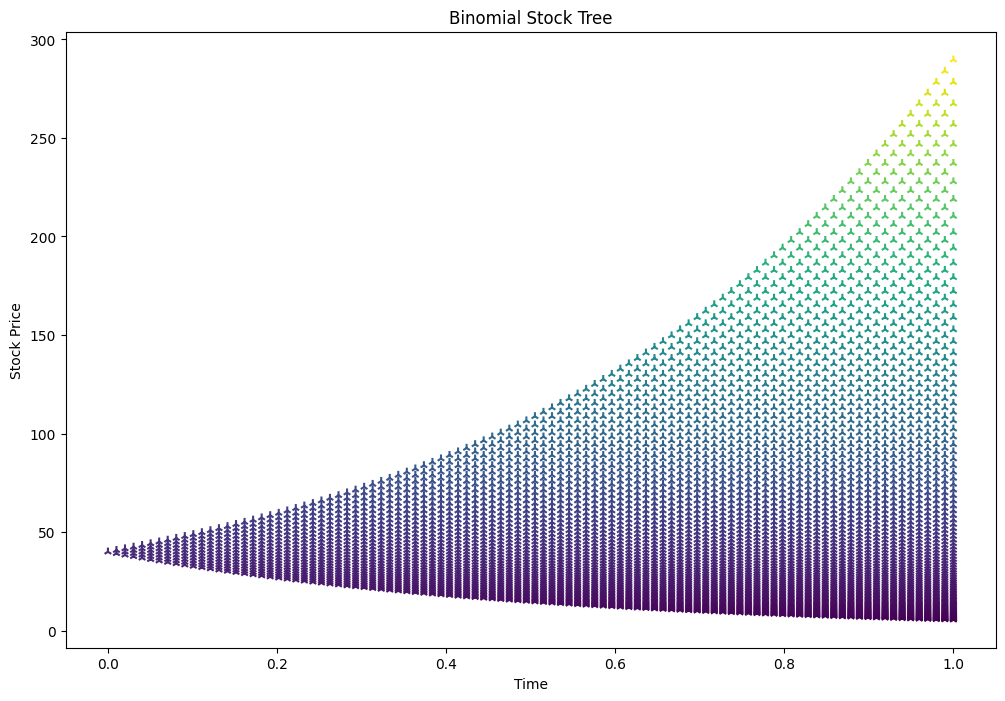

In [6]:
stock = binomial_tree_stock(S0, T, sigma, n)

# Create time values
time_values = np.linspace(0, T, n)
time_values_flat = [t for i in range(n) for t in [time_values[i]] * (i + 1)]
stock_values_flat = [stock[i, j] for i in range(n) for j in range(i + 1)]

# Plot the scatter plot
plt.figure(figsize=(12, 8))
my_cmap = plt.get_cmap('viridis')
plt.scatter(time_values_flat, stock_values_flat, c=stock_values_flat, cmap=my_cmap, marker='2')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Binomial Stock Tree')
plt.show()

In [7]:
bermudan_option_prices = binomial_bermudan_option_pricing(S0, K, T, r, sigma, n, early_exercise_dates, 'put')
american_option_prices = binomial_american_option_pricing(S0, K, T, r, sigma, n, 'put')
print("Bermudan Option Price:", bermudan_option_prices[0][0], "American Option Price:", american_option_prices[0][0])

Bermudan Option Price: 2.0583583319747016 American Option Price: 2.3164602527430107


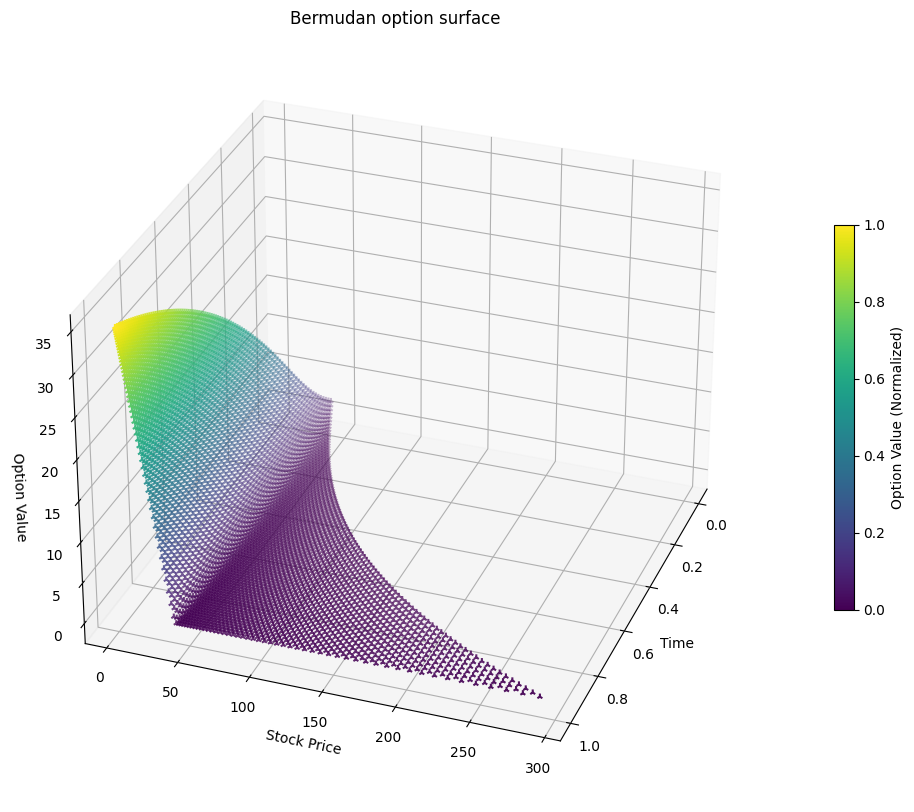

In [8]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30, 20)

option_values = [[bermudan_option_prices[i, j] for j in range(i + 1)] for i in range(n)]
# Normalize option values for colormap
option_values_flat = [value for row in option_values for value in row]
normalized_option_values = (option_values_flat - np.min(option_values_flat)) / (np.max(option_values_flat) - np.min(option_values_flat))

# Colormap
my_cmap = plt.get_cmap('viridis')

# Create a scatter plot with colors based on option values
scatter = ax.scatter3D(time_values_flat, stock_values_flat, option_values_flat, c=normalized_option_values, cmap=my_cmap, marker='2')

# Add color bar
cbar = plt.colorbar(scatter, shrink = 0.5)
cbar.set_label('Option Value (Normalized)')

ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('Option Value')
plt.title("Bermudan option surface")

plt.show()

## Plotting possible sample paths
We define a function that randomly picks a possible path in the dynamics of the model and plot a few examples

In [9]:
# Randomly (according to the risk-neutral probability p) picks a possible path in the matrix of the stock price
# (and the corresponding paths for the delta and the option value)
def sample_path(stock, delta, option, p):
    
    n = len(stock[0])
    stock_path = [stock[0][0]]
    delta_path = [delta[0][0]]
    option_path = [option[0][0]]
    
    j = 0
    for i in range(1, n):
        
        up = np.random.binomial(1, p)
        if up:
            j += 1
            stock_path.append(stock[i][j])
            option_path.append(option[i][j])
            if i != n - 1:
                delta_path.append(delta[i][j])
        else:
            stock_path.append(stock[i][j])
            option_path.append(option[i][j])
            if i != n - 1:
                delta_path.append(delta[i][j])
    
    return stock_path, delta_path, option_path

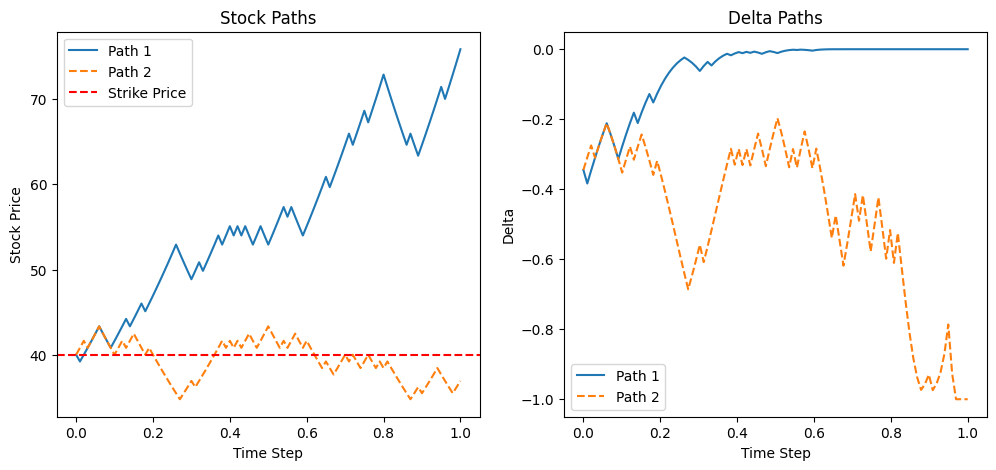

In [10]:
bermudan_delta = binomial_delta(bermudan_option_prices, sigma, T, n, S0)
stock_path_1, delta_path_1, option_path_1 = sample_path(stock, bermudan_delta, bermudan_option_prices, p)
stock_path_2, delta_path_2, option_path_2 = sample_path(stock, bermudan_delta, bermudan_option_prices, p)

time_values_s = np.linspace(0, 1, n + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(time_values_s, stock_path_1, label='Path 1', linestyle='-')
plt.plot(time_values_s, stock_path_2, label='Path 2', linestyle='--')
plt.axhline(y=K, color='r', linestyle='--', label='Strike Price')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title('Stock Paths')
plt.legend()

time_values_o = np.linspace(0, 1, n)
plt.subplot(1, 2, 2)
plt.plot(time_values_o, delta_path_1, label='Path 1', linestyle='-')
plt.plot(time_values_o, delta_path_2, label='Path 2', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Delta')
plt.title('Delta Paths')
plt.legend()

plt.show()

## Delta Hedging
We construct a $\Delta$-hedging portfolio, i.e. a portfolio consisting of $\Delta$-shares of the stock and short 1 (Bermudan) option, in order to offset the down-side risk. The position in the stock is update at every time step (continuous hedging).
For now (?) we assume the market to be frictionless.

In [11]:
class Portfolio:
    def __init__(self, cash=0, stock=0):
        self.cash = cash
        self.stock = stock

    def add_cash(self, amount):
        self.cash += amount
        
    def add_interest(self, r, t):
        self.cash *= np.exp(r * t)

    def buy_stock(self, shares, stock_price):
        cost = shares * stock_price
        self.cash -= cost
        self.stock += shares

    def get_portfolio_value(self, stock_price):
        total_value = self.cash + (self.stock * stock_price)
        return total_value

In [12]:
# Computes the dynamics of the Delta-neutral portfolio for a possible path described by stock_path, delta_path and option_path
# The output is the history of the portfolio value, stored as 'path'
def delta_hedging_portfolio(stock_path, delta_path, option_path, T, r):
    n = len(stock_path)
    dt = T / n
    # the initial position is given by buying the stock and short selling the option
    initial_shares = delta_path[0]
    initial_cash = option_path[0] - initial_shares * stock_path[0]
    pf = Portfolio(cash=initial_cash, stock=initial_shares)
    path = [pf.get_portfolio_value(stock_path[0]) - option_path[0]]
    
    for i in range(1, n - 1):
        pf.add_interest(r, dt)
        path.append(pf.get_portfolio_value(stock_path[i]) - option_path[i])
        shares_adjust = delta_path[i] - delta_path[i - 1]
        pf.buy_stock(shares_adjust, stock_path[i])
    pf.add_interest(r, dt)
    path.append(pf.get_portfolio_value(stock_path[n - 1]) - option_path[n - 1])
    
    return path

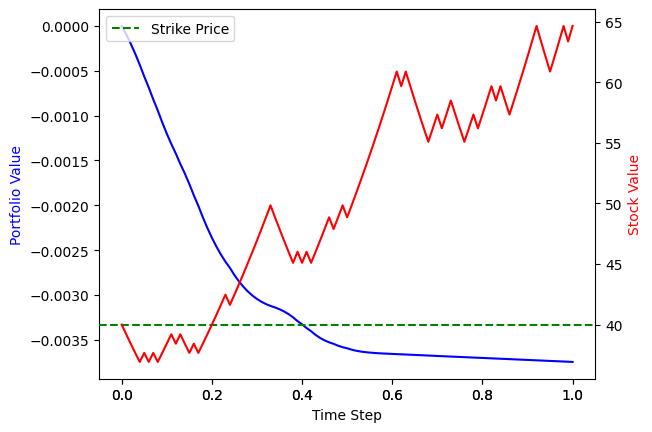

In [13]:
stock_path, delta_path, option_path = sample_path(stock, bermudan_delta, bermudan_option_prices, p)
portfolio_path = delta_hedging_portfolio(stock_path, delta_path, option_path, T, r)

time_values_s = np.linspace(0, 1, n + 1)

fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(time_values_s, portfolio_path, color='b', linestyle='-')
plt.axhline(y=K, color='g', linestyle='--', label='Strike Price')
ax.set_xlabel('Time Step')
ax.set_ylabel('Portfolio Value', color='b')

ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.plot(time_values_s, stock_path, color='r', linestyle='-')
ax2.set_ylabel('Stock Value', color='r')
plt.legend()

plt.show()